# Browsertrix Progress

When browsertrix-crawler runs it generates a line oriented JSON log file. We can use some of the messages to track how many URLs are getting queued for archiving against how many have been archived so far. This is potentially useful because you don't often know the dimensions of a website (the number of pages) a priori.

First lets read in all the log messages for a crawl that is underway. You can find these log files on disk in the collection's `logs` directory.

In [10]:
import json
import gzip

lines = list(map(json.loads, gzip.open('data/btrix-crawl.log.gz')))
lines[0:10]

[{'timestamp': '2024-05-08T21:10:57.754Z',
  'logLevel': 'info',
  'context': 'general',
  'message': 'Browsertrix-Crawler 1.1.2 (with warcio.js 2.2.1)',
  'details': {}},
 {'timestamp': '2024-05-08T21:10:57.756Z',
  'logLevel': 'info',
  'context': 'general',
  'message': 'Seeds',
  'details': [{'url': 'http://www.buffon.cnrs.fr/',
    'scopeType': 'prefix',
    'include': ['/^https?:\\/\\/www\\.buffon\\.cnrs\\.fr\\//'],
    'exclude': ['/.*fig=.*fig=.*/'],
    'allowHash': False,
    'depth': -1,
    'sitemap': None,
    'maxExtraHops': 0,
    'maxDepth': 1000000,
    '_excludeStr': '.*fig=.*fig=.*'}]},
 {'timestamp': '2024-05-08T21:10:58.631Z',
  'logLevel': 'info',
  'context': 'worker',
  'message': 'Creating 4 workers',
  'details': {}},
 {'timestamp': '2024-05-08T21:10:58.633Z',
  'logLevel': 'info',
  'context': 'worker',
  'message': 'Worker starting',
  'details': {'workerid': 0}},
 {'timestamp': '2024-05-08T21:10:58.633Z',
  'logLevel': 'info',
  'context': 'worker',
  'mess

Some of the messages have `context: crawlStatus` that provide information about how many pages have been crawled, and how many have yet to be crawled. For a long running crawl this can provide some useful information to see how long the crawl might take, since it's often difficult to known the dimensions of a website.

In [11]:
crawl_status = list(filter(lambda l: l['context'] == 'crawlStatus', lines))
crawl_status[0:2]

[{'timestamp': '2024-05-08T21:10:58.945Z',
  'logLevel': 'info',
  'context': 'crawlStatus',
  'message': 'Crawl statistics',
  'details': {'crawled': 0,
   'total': 1,
   'pending': 1,
   'failed': 0,
   'limit': {'max': 0, 'hit': False},
   'pendingPages': ['{"seedId":0,"started":"2024-05-08T21:10:58.637Z","extraHops":0,"url":"http://www.buffon.cnrs.fr/","added":"2024-05-08T21:10:57.860Z","depth":0}']}},
 {'timestamp': '2024-05-08T21:11:02.543Z',
  'logLevel': 'info',
  'context': 'crawlStatus',
  'message': 'Crawl statistics',
  'details': {'crawled': 0,
   'total': 64,
   'pending': 4,
   'failed': 0,
   'limit': {'max': 0, 'hit': False},
   'pendingPages': ['{"seedId":0,"started":"2024-05-08T21:11:02.166Z","extraHops":0,"url":"http://www.buffon.cnrs.fr/cs.php?lang=fr","added":"2024-05-08T21:11:01.887Z","depth":1}',
    '{"seedId":0,"started":"2024-05-08T21:11:02.166Z","extraHops":0,"url":"http://www.buffon.cnrs.fr/?lang=fr","added":"2024-05-08T21:11:01.885Z","depth":1}',
    '{"se

For analysis it can help to drop these messages into a Pandas DataFrame.

In [12]:
import pandas

df = pandas.DataFrame(crawl_status)
df

,timestamp,logLevel,context,message,details
0,2024-05-08T21:10:58.945Z,info,crawlStatus,Crawl statistics,"{'crawled': 0, 'total': 1, 'pending': 1, 'fail..."
1,2024-05-08T21:11:02.543Z,info,crawlStatus,Crawl statistics,"{'crawled': 0, 'total': 64, 'pending': 4, 'fai..."
2,2024-05-08T21:11:02.548Z,info,crawlStatus,Crawl statistics,"{'crawled': 0, 'total': 64, 'pending': 4, 'fai..."
3,2024-05-08T21:11:02.549Z,info,crawlStatus,Crawl statistics,"{'crawled': 0, 'total': 64, 'pending': 4, 'fai..."
4,2024-05-08T21:11:03.513Z,info,crawlStatus,Crawl statistics,"{'crawled': 1, 'total': 64, 'pending': 4, 'fai..."
...,...,...,...,...,...
41072,2024-05-09T10:20:58.946Z,info,crawlStatus,Crawl statistics,"{'crawled': 41069, 'total': 82927, 'pending': ..."
41073,2024-05-09T10:21:01.458Z,info,crawlStatus,Crawl statistics,"{'crawled': 41071, 'total': 82931, 'pending': ..."
41074,2024-05-09T10:21:01.479Z,info,crawlStatus,Crawl statistics,"{'crawled': 41071, 'total': 82931, 'pending': ..."
41075,2024-05-09T10:21:02.731Z,info,crawlStatus,Crawl statistics,"{'crawled': 41073, 'total': 82931, 'pending': ..."


Lets clean up the data a bit so we can work with it easier in Pandas.

First lets convert the timestamp column from a string to a datetime.

In [13]:
df.timestamp = pandas.to_datetime(df.timestamp)

Next, extract the `crawled` and `total` values from the serialized dictionary in the `details` column.

In [14]:
df['crawled'] = df.details.apply(lambda d: d['crawled'])
df['pages_to_crawl'] = df.details.apply(lambda d: d['total'])

Now we can plot the number of pages crawled, and the total pages to crawl (which changes as browsertrix discovers them in new pages).

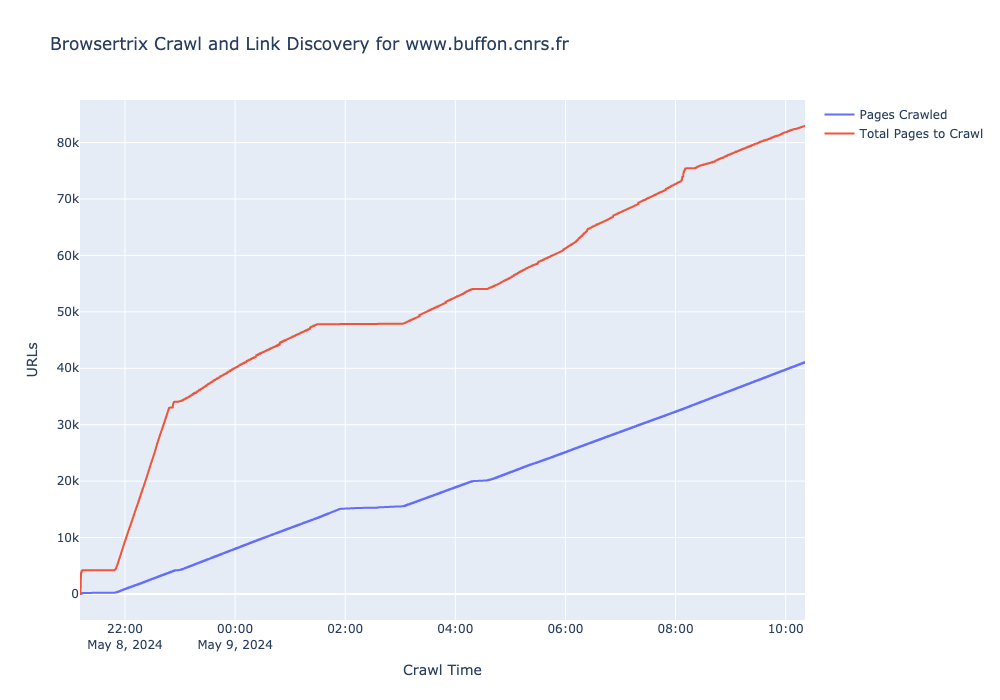

In [15]:
from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.timestamp,
        y=df.crawled,
        mode='lines',
        name='Pages Crawled',
        line={'shape': 'spline'}
    )
)

fig.add_trace(
    go.Scatter(
        x=df.timestamp,
        y=df.pages_to_crawl,
        mode='lines',
        name='Total Pages to Crawl',
        line={'shape': 'spline'}
    )
)

fig.update_layout(
    title='Browsertrix Crawl and Link Discovery for www.buffon.cnrs.fr',
    height=700,
    width=1000,
    yaxis_title='URLs',
    xaxis_title='Crawl Time'
)

fig.show('png')

Can we infer when the crawl is likely to end, based on what we've seen so far in the log?

In [16]:
from scipy.stats import linregress

crawled_line = linregress(x=df.timestamp.to_numpy(dtype=float), y=df.crawled)
total_line = linregress(x=df.timestamp.to_numpy(dtype=float), y=df.pages_to_crawl)

print(crawled_line)
print(total_line)

LinregressResult(slope=8.613151035034651e-10, intercept=-1477331216.634397, rvalue=0.9971003712935955, pvalue=0.0, stderr=3.243437549816389e-13, intercept_stderr=556323.4786451604)
LinregressResult(slope=1.3079919854168186e-09, intercept=-2243449518.966583, rvalue=0.9695111878039944, pvalue=0.0, stderr=1.6312215507858683e-12, intercept_stderr=2797916.8201512634)


TBD...